# EpidemIA

## Introdução

2019 foi um ano que irá ficar nos arautos da história, principalmente pela grande pandemia de uma nova doença com origem nos países asiáticos, uma evolução da SARS, denominada COVID-19.

A ideia de passar novamente por uma epidemia assusta qualquer pessoa nos dias atuais, e olhando as ações que foram tomadas, a única forma de minimizar os problemas e causas é a rápida identificação e comunicação, ou seja, informação.

Pensando no grande fluxo de dados públicos que poderíamos utilizar e na transparência de dados disponibilizados ao público, seria de fácil acesso para que pudéssemos traçar ligações entre doenças e sintomas aos locais de ocorrência, ou até com informações socioeconômicas, porém, infelizmente os dados que podemos acessar são escassos, e por mais que tenhamos acesso as estas informações do Portal da Saúde, só podemos visualizar dados de estatísticas vitais ou de mortalidade, algumas doenças epidemiológicas são citadas mas não existe a possibilidade de verificar novas doenças ou possíveis epidemias pela falta de padrão e informações mais qualificadas como localização, datas exatas, gênero, idade e etc ...

Com este objetivo, coletando as informações de forma padronizada e com máximo de aproveitamento, utilizaremos a Inteligência Artificial para criar modelos que realizam diagnósticos preliminares com base nos sintomas informados pelo usuário.

## Dados

Os datasets utilizados neste arquivos estão disponibilizados no site [Kaggle](https://www.kaggle.com/plarmuseau/sdsort).



### Importação dos dados

In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import coo_matrix
from scipy.sparse.linalg import svds
from sklearn.metrics.pairwise import cosine_similarity

### Leitura dos dados e criação dos dataframes

In [2]:
def read_data(filename, separator):
    """ Reads in the dataset, and returns a tuple of a pandas dataframe and a sparse matrix of symptom/disease/severity """
    data = pd.read_csv(filename, 
                       separator, 
                       usecols=[0,1,2], 
                       names=['symptom', 'disease','severities'], 
                       skiprows=1)

    data=data.dropna()
    
    # map each disease and symptom to a unique numeric value
    data['symptom'] = data['symptom'].astype("category")
    data['disease'] = data['disease'].astype("category")

    # create a sparse matrix of all the symptoms/severities
    sev = coo_matrix((data['severities'].astype(float),
                       (data['disease'].cat.codes.copy(),
                        data['symptom'].cat.codes.copy())))
    
    return data, sev, data.groupby(['disease']).severities.sum(), data['symptom'].cat.codes.copy()


In [13]:
all_symptoms = pd.read_csv('archives/all_symptoms.csv', ';')
all_diseases = pd.read_csv('archives/all_disease.csv', ';')

data, matrix, sum_disease, symptom = read_data('archives/dataset.csv', ';')
matrix.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Utilização do algorítmo de peso Okapi BM25

In [14]:
def bm25_weight(data, K1=1.5, B=0.75):
    """ Weighs each row of the matrix data by BM25 weighting """
    # calculate idf per term (symptom)
    N = float(data.shape[0])
    idf = np.log(N / (1 + np.bincount(data.col)))

    # calculate length_norm per document (disease)
    row_sums = np.squeeze(np.asarray(data.sum(1)))
    average_length = row_sums.sum() / N
    length_norm = (1.0 - B) + B * row_sums / average_length

    # weight matrix rows by bm25
    ret = coo_matrix(data)
    ret.data = ret.data * (K1 + 1.0) / (K1 * length_norm[ret.row] + ret.data) * idf[ret.col]
    return ret

symptom_count = data.groupby('symptom').size()


### Utilização de divisão singular do dataframe

O scipy.sparse.linalg.svds realiza a divisão linear entre as linhas e colunas e demonstra a singularidade entre cada nódulo do dataframe, mais informações [clique aqui](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.linalg.svds.html)

In [15]:
Ur, Si, VTr = svds(bm25_weight(matrix), k=100)
VTr=pd.DataFrame(VTr)

print("Doenças com nível de singularidade por cada peso ", Ur.shape)
print("---------------")

print("Valores singulares para cada nódulo", Si.shape)
print("---------------")

print("Sintomas com nível de singularidade por cada peso", VTr.shape)
print("---------------")

print("Quantidade de doenças", sum_disease.shape)
print("Quantidade de sintomas", symptom_count.shape)


Doenças com nível de singularidade por cada peso  (1166, 100)
---------------
Valores singulares para cada nódulo (100,)
---------------
Sintomas com nível de singularidade por cada peso (100, 272)
---------------
Quantidade de doenças (1166,)
Quantidade de sintomas (272,)


## Cosine Similarity

In [16]:
Disease_df = pd.DataFrame(cosine_similarity(Ur,VTr.T), columns=symptom_count.index, index=list(sum_disease.index)) 
Disease_df.head()

symptom,1,2,3,4,5,6,7,8,9,10,...,290,291,292,293,294,295,301,303,304,306
1,0.205484,0.272114,0.043167,-0.047387,-0.021459,0.015953,0.633309,-0.019115,-0.073327,-0.012857,...,-0.029264,-0.128676,-0.001867,-0.023130,-0.015429,0.002837,-0.018442,-0.040733,-0.045832,0.113079
2,-0.046659,-0.078299,-0.071982,0.063161,0.045799,-0.004549,-0.168562,0.049388,0.049649,-0.014734,...,0.074478,0.079732,0.024173,0.001410,-0.000718,-0.005382,-0.054203,0.022342,-0.022638,-0.059992
3,0.114272,0.381978,0.005659,0.049680,-0.043052,-0.014820,0.091332,-0.013405,-0.059609,0.009341,...,-0.033005,-0.009946,-0.020345,0.013041,0.019639,0.024916,-0.026550,-0.056702,0.056844,0.133652
4,0.017050,0.022067,-0.036084,0.040988,0.001289,0.038791,-0.050136,-0.021242,-0.006880,-0.012500,...,0.009720,-0.006165,-0.050009,-0.007232,0.016348,0.006368,0.022296,-0.005299,0.028985,0.002352
5,-0.034572,-0.030762,-0.051101,-0.086641,-0.025164,0.005332,-0.028281,0.025686,-0.041621,-0.038750,...,-0.017533,0.007516,0.002488,-0.010030,0.002354,0.009506,0.020183,0.000352,0.013323,0.140841


### Demonstração de usabilidade

In [17]:
#Sintoma 35 = Foot pain

print("Sintoma ", all_symptoms[all_symptoms['Symptom_id'] == 272])
print("Top 10 prováveis doênças relacionadas")
print("--------------------------------------")
listProb = Disease_df[272].sort_values(ascending=False).index
for x in listProb[:10]:
    print(x, all_diseases[all_diseases['Disease_id'] == x].Disease_desc.values)

Sintoma       Symptom_id Symptom_desc
227         272   Skin bumps
Top 10 prováveis doênças relacionadas
--------------------------------------
1170 ['Viral exanthem rash from viral infection']
877 ['Acne pimples']
684 ['Sebaceous cyst sac under the skin']
188 ['Contact dermatitis contact skin irritation']
884 ['Cradle cap infant scalp rash']
431 ['Lipoma benign fatty tumor']
79 ['Balanitis penis swelling']
1057 ['Hidradenitis suppurativa chronic collections of pus']
443 ['Lymphangitis lymph tissue inflammation']
860 ['Fifth disease erythema infectiosum, viral illness']


### Compilando os exemplos acima em uma classe

In [22]:
class preliminary_diagnosis():    
    def __init__(self, b=0.3, k=1, symptoms = pd.DataFrame(), diseases = pd.DataFrame()):
        self.b = b
        self.k = k
        self.all_symptoms = symptoms
        self.all_diseases = diseases
        
        
    def bm25_weight(self, data, K1=1, B=0.3):
        """ Weighs each row of the matrix data by BM25 weighting """
        # calculate idf per term (symptom)
        N = float(data.shape[0])
        idf = np.log(N / (1 + np.bincount(data.col)))

        # calculate length_norm per document (disease)
        row_sums = np.squeeze(np.asarray(data.sum(1)))
        average_length = row_sums.sum() / N
        length_norm = (1.0 - B) + B * row_sums / average_length

        # weight matrix rows by bm25
        ret = coo_matrix(data)
        ret.data = ret.data * (K1 + 1.0) / (K1 * length_norm[ret.row] + ret.data) * idf[ret.col]
        return ret
    
    
    def fit(self, filename, separator):
        """ Reads in the dataset, and returns a tuple of a pandas dataframe and a sparse matrix of symptom/disease/severity """
        data = pd.read_csv(filename, 
                           separator, 
                           usecols=[0,1,2], 
                           names=['symptom', 'disease','severities'], 
                           skiprows=1)

        data=data.dropna()

        # map each disease and symptom to a unique numeric value
        data['symptom'] = data['symptom'].astype("category")
        data['disease'] = data['disease'].astype("category")

        # create a sparse matrix of all the symptoms/severities
        sev = coo_matrix((data['severities'].astype(float),
                           (data['disease'].cat.codes.copy(),
                            data['symptom'].cat.codes.copy())))

        self.data = data
        self.matrix = sev
        self.sum_disease = data.groupby(['disease']).severities.sum()
        self.symptom = data['symptom'].cat.codes.copy()
        
        self.symptom_count = data.groupby('symptom').size()
        
        Ur, Si, VTr = svds(self.bm25_weight(self.matrix), k=100)
        VTr = pd.DataFrame(VTr)
        
        self.dataset_result = pd.DataFrame(cosine_similarity(Ur,VTr.T), columns=self.symptom_count.index, index=list(self.sum_disease.index)) 
        return self.dataset_result

    def get_diseases_by_symptoms(self, symptom_id):
        print("Sintoma ", (self.all_symptoms[self.all_symptoms['Symptom_id'] == symptom_id])['Symptom_desc'].values[0])
        print("Top 10 prováveis doênças relacionadas")
        print("--------------------------------------")
        listProb = self.dataset_result[symptom_id].sort_values(ascending=False).index
        for x in listProb[:10]:
            print(x, self.all_diseases[self.all_diseases['Disease_id'] == x].Disease_desc.values)

### Utilizando a cognição preliminar pelo objeto de classe

In [23]:
all_symptoms = pd.read_csv('archives/all_symptoms.csv', ';')
all_diseases = pd.read_csv('archives/all_disease.csv', ';')

modelo = preliminary_diagnosis(k=1, b=0.3, symptoms = all_symptoms, diseases = all_diseases)
modelo.fit('archives/dataset.csv', ';')
modelo.get_diseases_by_symptoms(35)

Sintoma  Foot pain
Top 10 prováveis doênças relacionadas
--------------------------------------
1097 ['Flat feet pes planus']
1098 ['Heel spur']
621 ['Puncture wound']
582 ['Plantar wart human papilloma virus infection, foot warts']
947 ['Foot fracture broken foot']
1287 ['Foot sprain']
963 ["Sever's disease calcaneal apophysitis, common cause of heel pain"]
581 ['Plantar fasciitis inflammation of tissue at the bottom of the foot']
324 ['Hammer toes toe deformity']
124 ['Calluses and corns']


## Evaluating - Avaliando a performance do modelo

In [18]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import log_loss, accuracy_score

import scikitplot.plotters as skplt

In [20]:
def evaluate(X, y, clf=None):
    probas = cross_val_predict(clf, X, y, cv=StratifiedKFold(n_splits=5, random_state=8, shuffle=True), 
                               n_jobs=-1, method='predict_proba', verbose=2)
    
    pred_indices = np.argmax(probas, axis=1)
    classes = np.unique(y)
    preds = classes[pred_indices]
    print('Log loss: {}'.format(log_loss(y, probas)))
    print('Accuracy: {}'.format(accuracy_score(y, preds)))
    skplt.plot_confusion_matrix(y, preds)


In [30]:
modelo = preliminary_diagnosis(k=1, b=0.3, symptoms = all_symptoms, diseases = all_diseases)
X = modelo.fit('archives/dataset.csv', ';')

weight = bm25_weight(matrix)
weight_df = pd.DataFrame(weight.toarray())
y = weight_df.max(axis=1).astype('int').values

c:\users\arthu\anaconda3\envs\epidemia\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.1s finished
c:\users\arthu\anaconda3\envs\epidemia\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


Log loss: 1.6032106051839263
Accuracy: 0.4794168096054888


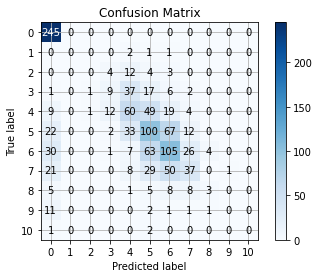

In [31]:
evaluate(X, y, clf=LogisticRegression())


c:\users\arthu\anaconda3\envs\epidemia\lib\site-packages\sklearn\model_selection\_split.py:668: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   48.0s finished
c:\users\arthu\anaconda3\envs\epidemia\lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_confusion_matrix is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_confusion_matrix instead.
  warnings.warn(msg, category=FutureWarning)


Log loss: 1.5938048736609824
Accuracy: 0.5283018867924528


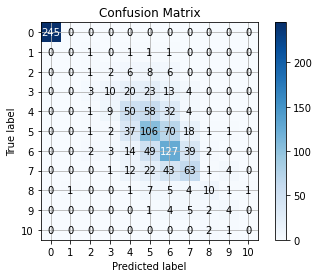

In [29]:
evaluate(X, y, clf=XGBClassifier())
